In [30]:
import os
import io

import numpy as np
import pandas as pd
import scipy.io as sio
from google.cloud import storage


In [31]:
# Configure which .mat object to load (defaults to S001)
mat_object = os.getenv('GCS_OBJECT_MAIN', 'Wearable SSVEP Dataset/S001.mat')
subject_id = os.path.splitext(os.path.basename(mat_object))[0]

client = storage.Client.from_service_account_json(
    os.getenv('GOOGLE_APPLICATION_CREDENTIALS')
)
bucket = client.bucket(os.getenv('GCP_BUCKET_NAME'))

print(f'Loading {mat_object} for subject {subject_id}')
blob = bucket.blob(mat_object)
data_bytes = blob.download_as_bytes()
mat = sio.loadmat(io.BytesIO(data_bytes))

data = mat['data']  # expected shape (channels, time, electrode, block, target)
print('Loaded data shape:', data.shape)

Loading Wearable SSVEP Dataset/S001.mat for subject S001
Loaded data shape: (8, 710, 2, 10, 12)


In [32]:
# Build epoch-level dataframe for a single subject (one row per electrode x block x target)
expected_shape = (8, 710, 2, 10, 12)
if data.shape != expected_shape:
    raise ValueError(f'Unexpected data shape {data.shape}, expected {expected_shape}')

rows = []
electrode_map = {0: 'wet', 1: 'dry'}

for e_idx in range(data.shape[2]):
    for b_idx in range(data.shape[3]):
        for t_idx in range(data.shape[4]):
            rows.append(
                {
                    'subject': subject_id,
                    'electrode': electrode_map.get(e_idx, str(e_idx)),
                    'block': b_idx + 1,   # 1-based
                    'target': t_idx + 1,  # 1-based
                    'signal': data[:, :, e_idx, b_idx, t_idx],  # shape (8, 710)
                }
            )

all_epochs = pd.DataFrame(rows)
print('DataFrame shape:', all_epochs.shape)
print(all_epochs.head())
print('Electrode counts:')
print(all_epochs['electrode'].value_counts())


DataFrame shape: (240, 5)
  subject electrode  block  target  \
0    S001       wet      1       1   
1    S001       wet      1       2   
2    S001       wet      1       3   
3    S001       wet      1       4   
4    S001       wet      1       5   

                                              signal  
0  [[-52325.52005800724, -53157.22841961553, -554...  
1  [[-56806.91044371786, -58819.819022406286, -60...  
2  [[-58424.81901793594, -57290.15513003797, -551...  
3  [[-59719.47668310861, -61462.01857698074, -609...  
4  [[-57667.36314698238, -60079.16093344456, -608...  
Electrode counts:
electrode
wet    120
dry    120
Name: count, dtype: int64


In [33]:
# Build full multi-subject epoch DataFrame (102 subjects x 240 epochs)

import re


def load_mat_from_gcs(filepath):
    """Download a .mat from GCS and return the 'data' array."""
    client = storage.Client.from_service_account_json(
        os.getenv('GOOGLE_APPLICATION_CREDENTIALS')
    )
    bucket = client.bucket(os.getenv('GCP_BUCKET_NAME'))
    blob = bucket.blob(filepath)
    bytes_data = blob.download_as_bytes()
    mat = sio.loadmat(io.BytesIO(bytes_data))
    if 'data' not in mat:
        raise KeyError(f"'data' variable missing in {filepath}")
    arr = mat['data']
    if arr.shape != (8, 710, 2, 10, 12):
        raise ValueError(f"Unexpected shape {arr.shape} in {filepath}")
    return arr


def build_subject_df(subject_id, data):
    """Convert one subject's 5-D array into a 240-row DataFrame."""
    expected = (8, 710, 2, 10, 12)
    if data.shape != expected:
        raise ValueError(f"Unexpected shape {data.shape}, expected {expected}")

    rows = []
    for e_idx in range(2):
        for b_idx in range(10):
            for t_idx in range(12):
                rows.append(
                    {
                        'subject': subject_id,
                        'electrode': 'wet' if e_idx == 0 else 'dry',
                        'block': b_idx + 1,
                        'target': t_idx + 1,
                        'signal': data[:, :, e_idx, b_idx, t_idx],
                    }
                )
    return pd.DataFrame(rows)


# List all subject .mat files (skip non-subject files like Impedance.mat)
client = storage.Client.from_service_account_json(
    os.getenv('GOOGLE_APPLICATION_CREDENTIALS')
)
bucket = client.bucket(os.getenv('GCP_BUCKET_NAME'))
prefix = 'Wearable SSVEP Dataset/'
mat_files = []
for b in bucket.list_blobs(prefix=prefix):
    name = b.name
    base = os.path.basename(name)
    if not base.endswith('.mat'):
        continue
    if not re.match(r'S\d+\.mat$', base):
        continue  # skip non-subject files (e.g., Impedance.mat)
    mat_files.append(name)
mat_files.sort()
print(f'Found {len(mat_files)} subject .mat files')

# Build combined DataFrame
all_subject_dfs = []
for fp in mat_files:
    subject_id = os.path.splitext(os.path.basename(fp))[0]
    try:
        data_arr = load_mat_from_gcs(fp)
    except (KeyError, ValueError) as exc:
        print(f'Skipping {fp}: {exc}')
        continue
    df_subj = build_subject_df(subject_id, data_arr)
    all_subject_dfs.append(df_subj)

full_df = pd.concat(all_subject_dfs, ignore_index=True)

# Summaries
print('full_df shape:', full_df.shape)
print(full_df.head())
print('Subject counts:')
print(full_df['subject'].value_counts())
print('Electrode counts:')
print(full_df['electrode'].value_counts())


Found 102 subject .mat files
full_df shape: (24480, 5)
  subject electrode  block  target  \
0    S001       wet      1       1   
1    S001       wet      1       2   
2    S001       wet      1       3   
3    S001       wet      1       4   
4    S001       wet      1       5   

                                              signal  
0  [[-52325.52005800724, -53157.22841961553, -554...  
1  [[-56806.91044371786, -58819.819022406286, -60...  
2  [[-58424.81901793594, -57290.15513003797, -551...  
3  [[-59719.47668310861, -61462.01857698074, -609...  
4  [[-57667.36314698238, -60079.16093344456, -608...  
Subject counts:
subject
S001    240
S002    240
S003    240
S004    240
S005    240
       ... 
S098    240
S099    240
S100    240
S101    240
S102    240
Name: count, Length: 102, dtype: int64
Electrode counts:
electrode
wet    12240
dry    12240
Name: count, dtype: int64


In [34]:
import numpy as np
from scipy.signal import butter, filtfilt, iirnotch

FS = 250  # sampling rate in Hz (given by the dataset paper)


def bandpass(epoch, low=8, high=90, fs=FS, order=4):
    """
    Band-pass filter: keep only frequencies between `low` and `high` Hz.
    epoch: array of shape (n_channels, n_samples)
    """
    nyq = fs / 2
    b, a = butter(order, [low / nyq, high / nyq], btype="band")
    return filtfilt(b, a, epoch, axis=-1)


def notch(epoch, freq=50, fs=FS, q=30):
    """
    Notch filter: remove a narrow band around `freq` Hz (e.g. 50 Hz mains noise).
    """
    nyq = fs / 2
    w0 = freq / nyq
    b, a = iirnotch(w0, Q=q)
    return filtfilt(b, a, epoch, axis=-1)


def preprocess_epoch(epoch_raw):
    """
    Full preprocessing for a single trial.
    Input:  epoch_raw shape (8, 710)
    Output: preprocessed epoch shape (8, 500)
    """
    # Always work in float64 to avoid numerical weirdness
    epoch = epoch_raw.astype(np.float64)

    # 1) Band-pass 8–90 Hz: keep SSVEP fundamentals + harmonics, remove drifts & ultra-high noise
    epoch = bandpass(epoch, low=8, high=90, fs=FS, order=4)

    # 2) Notch 50 & 100 Hz: remove mains electrical hum and its first harmonic
    epoch = notch(epoch, freq=50, fs=FS, q=30)
    epoch = notch(epoch, freq=100, fs=FS, q=30)

    # 3) Baseline correction using -0.5s to 0s (first 125 samples at 250 Hz)
    baseline = epoch[:, :125].mean(axis=-1, keepdims=True)
    epoch = epoch - baseline

    # 4) Trim to main SSVEP window.
    #    0.5s pre + ~0.14s visual delay => start ~0.64s after trial onset: sample 160
    #    2s of stimulation => 500 samples => 160:660
    epoch = epoch[:, 160:660]  # shape (8, 500)

    # 5) Per-epoch, per-channel z-score:
    #    make each channel have mean 0 and std 1 in this epoch, so scales are comparable.
    mean = epoch.mean(axis=-1, keepdims=True)
    std = epoch.std(axis=-1, keepdims=True) + 1e-8
    epoch = (epoch - mean) / std

    return epoch


In [35]:
full_df['signal_pp'] = full_df['signal'].apply(preprocess_epoch)
pp_full_df = full_df

In [36]:
pp_full_df.head()

,subject,electrode,block,target,signal,signal_pp
0,S001,wet,1,1,"[[-52325.52005800724, -53157.22841961553, -554...","[[1.7032953466442327, 1.005246832885553, -0.69..."
1,S001,wet,1,2,"[[-56806.91044371786, -58819.819022406286, -60...","[[2.117382919391313, 0.2370555702658194, -1.90..."
2,S001,wet,1,3,"[[-58424.81901793594, -57290.15513003797, -551...","[[-3.406244938902054, -0.627152174409783, 3.07..."
3,S001,wet,1,4,"[[-59719.47668310861, -61462.01857698074, -609...","[[0.2641990410475281, -0.3935579522876416, -0...."
4,S001,wet,1,5,"[[-57667.36314698238, -60079.16093344456, -608...","[[0.6330417927252154, -0.27745217316763204, -0..."


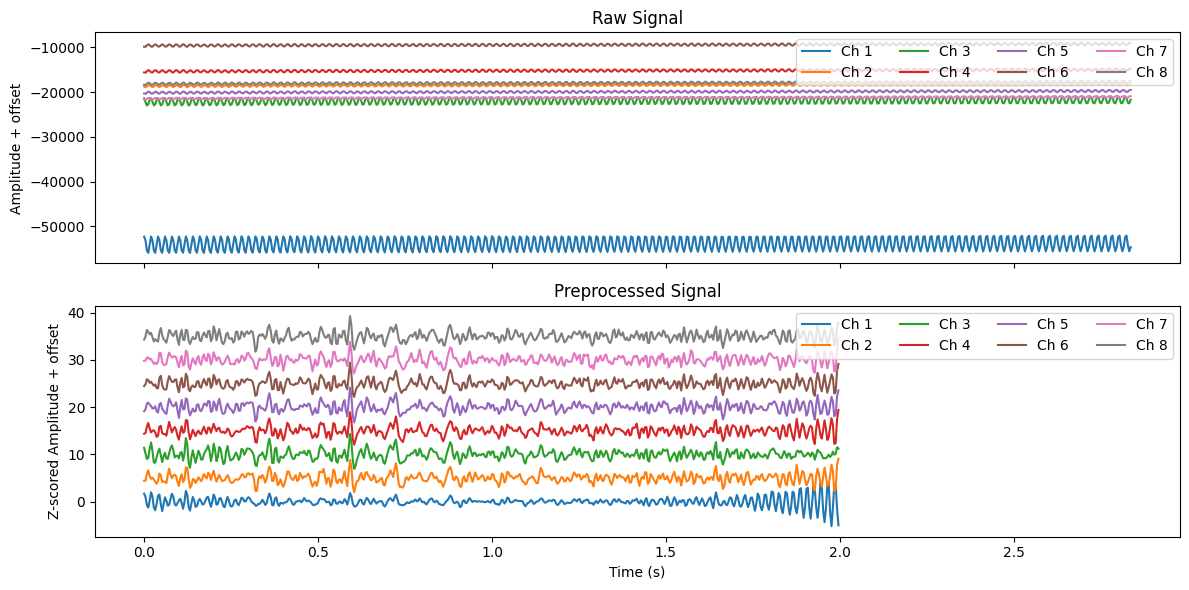

In [39]:
# visual check of preprocessing
import matplotlib.pyplot as plt
epoch_raw = pp_full_df.iloc[0]['signal']
epoch_pp = pp_full_df.iloc[0]['signal_pp']
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
time_raw = np.arange(epoch_raw.shape[1]) / FS  # in seconds
axes[0].set_title('Raw Signal')
for ch_idx in range(epoch_raw.shape[0]):
    axes[0].plot(time_raw, epoch_raw[ch_idx, :] + ch_idx * 5, label=f'Ch {ch_idx+1}')
axes[0].set_ylabel('Amplitude + offset')
axes[0].legend(loc='upper right', ncol=4)
time_pp = np.arange(epoch_pp.shape[1]) / FS  # in seconds
axes[1].set_title('Preprocessed Signal')
for ch_idx in range(epoch_pp.shape[0]):
    axes[1].plot(time_pp, epoch_pp[ch_idx, :] + ch_idx * 5, label=f'Ch {ch_idx+1}')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Z-scored Amplitude + offset')
axes[1].legend(loc='upper right', ncol=4)
plt.tight_layout()
plt.show()

In [40]:
# Use only wet-electrode trials
mask = (pp_full_df['electrode'] == 'wet')
df_wet = pp_full_df.loc[mask].reset_index(drop=True)

# Stack preprocessed signals into a big 3D array: (n_trials, n_channels, n_samples)
X = np.stack(df_wet['signal_pp'].values)   # shape (N_trials, 8, 500)

# Targets: 1..12 in the dataset; convert to 0..11 for indexing convenience
y = df_wet['target'].values - 1

# Keep subject labels for optional per-subject analysis
subjects = df_wet['subject'].values

print("X shape:", X.shape)   # (N_wet_trials, 8, 500)
print("y shape:", y.shape, "unique targets:", np.unique(y))

X shape: (12240, 8, 500)
y shape: (12240,) unique targets: [ 0  1  2  3  4  5  6  7  8  9 10 11]


In [41]:
df_wet.head()

,subject,electrode,block,target,signal,signal_pp
0,S001,wet,1,1,"[[-52325.52005800724, -53157.22841961553, -554...","[[1.7032953466442327, 1.005246832885553, -0.69..."
1,S001,wet,1,2,"[[-56806.91044371786, -58819.819022406286, -60...","[[2.117382919391313, 0.2370555702658194, -1.90..."
2,S001,wet,1,3,"[[-58424.81901793594, -57290.15513003797, -551...","[[-3.406244938902054, -0.627152174409783, 3.07..."
3,S001,wet,1,4,"[[-59719.47668310861, -61462.01857698074, -609...","[[0.2641990410475281, -0.3935579522876416, -0...."
4,S001,wet,1,5,"[[-57667.36314698238, -60079.16093344456, -608...","[[0.6330417927252154, -0.27745217316763204, -0..."


In [42]:
# Use only dry-electrode trials
mask = (pp_full_df['electrode'] == 'dry')
df_dry = pp_full_df.loc[mask].reset_index(drop=True)

# Stack preprocessed signals into a big 3D array: (n_trials, n_channels, n_samples)
X = np.stack(df_dry['signal_pp'].values)   # shape (N_trials, 8, 500)

# Targets: 1..12 in the dataset; convert to 0..11 for indexing convenience
y = df_dry['target'].values - 1

# Keep subject labels for optional per-subject analysis
subjects = df_dry['subject'].values

print("X shape:", X.shape)   # (N_dry_trials, 8, 500)
print("y shape:", y.shape, "unique targets:", np.unique(y))

X shape: (12240, 8, 500)
y shape: (12240,) unique targets: [ 0  1  2  3  4  5  6  7  8  9 10 11]


In [ ]:
df_dry.head()

,subject,electrode,block,target,signal,signal_pp
0,S001,dry,1,1,"[[11008.769929931756, 11086.106961137471, 1107...","[[0.8215276341275753, -0.3991914594520168, -0...."
1,S001,dry,1,2,"[[11050.075951223133, 11012.793243693903, 1091...","[[-0.7603191746210111, 0.14115532653135515, 0...."
2,S001,dry,1,3,"[[11037.246050670508, 10992.006122589477, 1089...","[[-0.5081136095987432, 0.5326038935662898, 1.4..."
3,S001,dry,1,4,"[[10876.537017615856, 10805.905509347052, 1080...","[[0.988190496180082, 0.024042369584211083, -0...."
4,S001,dry,1,5,"[[10760.307953376052, 10770.902679616373, 1086...","[[-1.4313427569492077, 0.06254557478582827, -0..."


In [43]:
# compare wet and dry electrode trials
df_compare = pp_full_df.pivot_table(
    index=['subject', 'block', 'target'],
    columns='electrode',
    values='signal_pp'
).reset_index()
df_compare.head()

electrode,subject,block,target,dry,wet
0,S001,1,1,"[[0.8215276341275753, -0.3991914594520168, -0....","[[1.7032953466442327, 1.005246832885553, -0.69..."
1,S001,1,2,"[[-0.7603191746210111, 0.14115532653135515, 0....","[[2.117382919391313, 0.2370555702658194, -1.90..."
2,S001,1,3,"[[-0.5081136095987432, 0.5326038935662898, 1.4...","[[-3.406244938902054, -0.627152174409783, 3.07..."
3,S001,1,4,"[[0.988190496180082, 0.024042369584211083, -0....","[[0.2641990410475281, -0.3935579522876416, -0...."
4,S001,1,5,"[[-1.4313427569492077, 0.06254557478582827, -0...","[[0.6330417927252154, -0.27745217316763204, -0..."


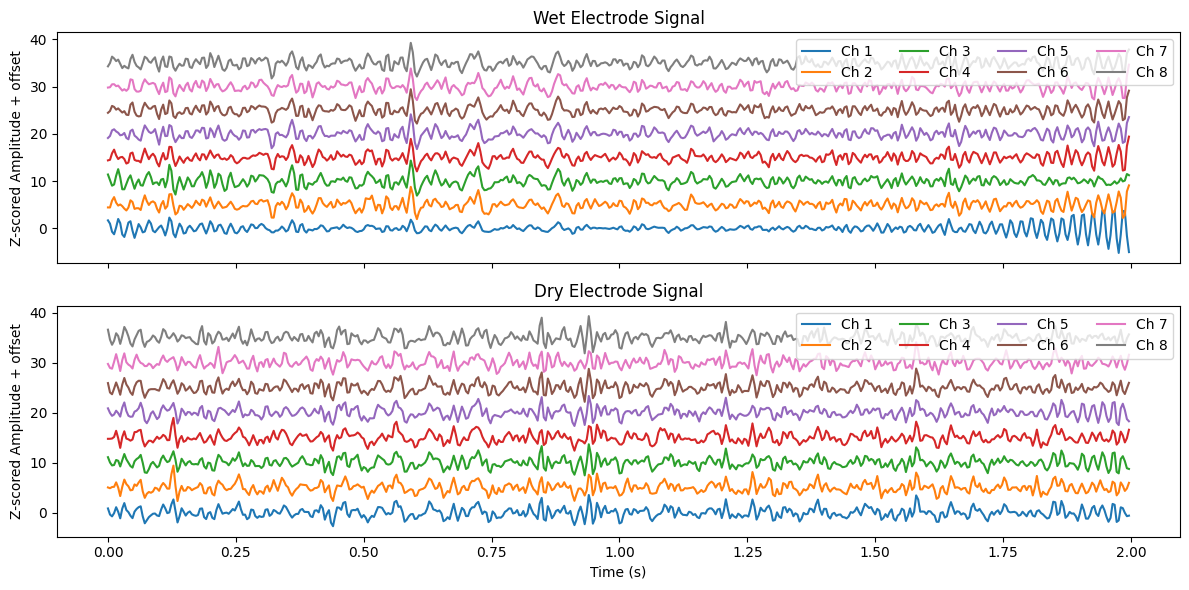

In [44]:
# visual comparison of wet vs dry for one trial
import matplotlib.pyplot as plt
trial_idx = 0
row = df_compare.iloc[trial_idx]
epoch_wet = row['wet']  # shape (8, 500)
epoch_dry = row['dry']  # shape (8, 500)
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
time = np.arange(epoch_wet.shape[1]) / FS  # in seconds
axes[0].set_title('Wet Electrode Signal')
for ch_idx in range(epoch_wet.shape[0]):
    axes[0].plot(time, epoch_wet[ch_idx, :] + ch_idx * 5, label=f'Ch {ch_idx+1}')
axes[0].set_ylabel('Z-scored Amplitude + offset')
axes[0].legend(loc='upper right', ncol=4)
axes[1].set_title('Dry Electrode Signal')
for ch_idx in range(epoch_dry.shape[0]):
    axes[1].plot(time, epoch_dry[ch_idx, :] + ch_idx * 5, label=f'Ch {ch_idx+1}')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Z-scored Amplitude + offset')
axes[1].legend(loc='upper right', ncol=4)
plt.tight_layout()
plt.show()

In [45]:
import numpy as np
from sklearn.cross_decomposition import CCA

FS = 250          # sampling rate (Hz)
N_HARMONICS = 5   # number of harmonics to use in references

# Target-wise frequency & phase from stimulation_information.pdf -----

FREQ_PER_TARGET = np.array([
    9.25,   # target 1  → '1'
    11.25,  # target 2  → '2'
    13.25,  # target 3  → '3'
    9.75,   # target 4  → '4'
    11.75,  # target 5  → '5'
    13.75,  # target 6  → '6'
    10.25,  # target 7  → '7'
    12.25,  # target 8  → '8'
    14.25,  # target 9  → '9'
    10.75,  # target 10 → '0'
    12.75,  # target 11 → '*'
    14.75   # target 12 → '#'
], dtype=float)

PHASE_PER_TARGET = np.array([
    0.0 * np.pi,  # target 1
    0.0 * np.pi,  # target 2
    0.0 * np.pi,  # target 3
    0.5 * np.pi,  # target 4
    0.5 * np.pi,  # target 5
    0.5 * np.pi,  # target 6
    1.0 * np.pi,  # target 7
    1.0 * np.pi,  # target 8
    1.0 * np.pi,  # target 9
    1.5 * np.pi,  # target 10
    1.5 * np.pi,  # target 11
    1.5 * np.pi   # target 12
], dtype=float)

In [46]:
# Build reference signals per TARGET (freq + phase) -----

def make_ref_signals_targetwise(freqs, phases, n_samples, fs=FS, n_harmonics=N_HARMONICS):
    """
    Build one reference matrix per target using that target's frequency AND phase.

    Returns: list of length n_targets
        refs[k] has shape (2 * n_harmonics, n_samples)
    """
    t = np.arange(n_samples) / fs
    refs = []

    for f, phi in zip(freqs, phases):
        components = []
        for h in range(1, n_harmonics + 1):
            # sin and cos with correct phase offset
            components.append(np.sin(2 * np.pi * h * f * t + phi))
            components.append(np.cos(2 * np.pi * h * f * t + phi))
        Y = np.stack(components, axis=0)  # (2 * n_harmonics, n_samples)
        refs.append(Y)

    return refs

In [ ]:
# ----- 3. CCA-based predictor using those references -----

def cca_predict(X, freqs=FREQ_PER_TARGET, phases=PHASE_PER_TARGET,
                fs=FS, n_harmonics=N_HARMONICS):
    """
    X : ndarray, shape (n_trials, n_channels, n_samples)
        Preprocessed EEG epochs (e.g. (N, 8, 500))

    Returns
    -------
    y_pred : ndarray, shape (n_trials,)
        Predicted target indices in 0..(n_targets-1)
        (add +1 if you want to match your original 1..12 labels)
    """
    n_trials, n_channels, n_samples = X.shape

    # Precompute reference signals once
    refs = make_ref_signals_targetwise(freqs, phases, n_samples, fs, n_harmonics)

    cca = CCA(n_components=1)
    y_pred = np.zeros(n_trials, dtype=int)

    for i in range(n_trials):
        trial = X[i].T     # (n_samples, n_channels)
        corrs = []

        for Y in refs:     # Y: (2*n_harmonics, n_samples)
            Y_t = Y.T      # (n_samples, 2*n_harmonics)

            # CCA between EEG trial and reference signals
            cca.fit(trial, Y_t)
            U, V = cca.transform(trial, Y_t)

            # correlation between first canonical components
            corr = np.corrcoef(U[:, 0], V[:, 0])[0, 1]
            corrs.append(corr)

        # choose target with highest correlation
        y_pred[i] = int(np.argmax(corrs))

    return y_pred

In [ ]:
# Wet-only example
df_wet = full_df[full_df['electrode'] == 'wet'].reset_index(drop=True)
X = np.stack(df_wet['signal_pp'].values)       # (N_trials, 8, 500)
y_true = df_wet['target'].values - 1          # 0..11

y_pred = cca_predict(X)

from sklearn.metrics import accuracy_score
print("CCA accuracy (wet):", accuracy_score(y_true, y_pred))

/Users/tanya/.pyenv/versions/3.10.6/envs/inkling/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/Users/tanya/.pyenv/versions/3.10.6/envs/inkling/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/Users/tanya/.pyenv/versions/3.10.6/envs/inkling/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


CCA accuracy (wet): 0.7080882352941177


In [ ]:
# Dry-only example
df_dry = full_df[full_df['electrode'] == 'dry'].reset_index(drop=True)
X = np.stack(df_dry['signal_pp'].values)
y_true = df_dry['target'].values - 1
y_pred = cca_predict(X)
from sklearn.metrics import accuracy_score
print("CCA accuracy (dry):", accuracy_score(y_true, y_pred))

/Users/tanya/.pyenv/versions/3.10.6/envs/inkling/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/Users/tanya/.pyenv/versions/3.10.6/envs/inkling/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/Users/tanya/.pyenv/versions/3.10.6/envs/inkling/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


CCA accuracy (dry): 0.8422385620915033


Turning phase-aware CCA into FBCCA

In [ ]:
import numpy as np
from scipy.signal import butter, filtfilt
from sklearn.cross_decomposition import CCA

FS = 250          # sampling rate (Hz)
N_HARMONICS = 5   # harmonics for refs

# ----- Stimulation mapping from stimulation_information.pdf -----
FREQ_PER_TARGET = np.array([
    9.25,   # target 1  → '1'
    11.25,  # target 2  → '2'
    13.25,  # target 3  → '3'
    9.75,   # target 4  → '4'
    11.75,  # target 5  → '5'
    13.75,  # target 6  → '6'
    10.25,  # target 7  → '7'
    12.25,  # target 8  → '8'
    14.25,  # target 9  → '9'
    10.75,  # target 10 → '0'
    12.75,  # target 11 → '*'
    14.75   # target 12 → '#'
], dtype=float)

PHASE_PER_TARGET = np.array([
    0.0 * np.pi,  # 1
    0.0 * np.pi,  # 2
    0.0 * np.pi,  # 3
    0.5 * np.pi,  # 4
    0.5 * np.pi,  # 5
    0.5 * np.pi,  # 6
    1.0 * np.pi,  # 7
    1.0 * np.pi,  # 8
    1.0 * np.pi,  # 9
    1.5 * np.pi,  # 10
    1.5 * np.pi,  # 11
    1.5 * np.pi   # 12
], dtype=float)

# ----- Filter bank (you can tweak these bands) -----

FILTER_BANKS = [
    (8, 90),
    (15, 90),
    (20, 90),
]

M = len(FILTER_BANKS)

# Power-law weights
WEIGHTS = np.array([1.0, 0.5, 0.25])


In [53]:
def bandpass_nd(data, low, high, fs=FS, order=4):
    """
    Band-pass filter along the last axis of an N-D array.
    data: (..., n_samples)
    """
    nyq = fs / 2
    b, a = butter(order, [low / nyq, high / nyq], btype="band")
    return filtfilt(b, a, data, axis=-1)


def make_ref_signals_targetwise(freqs, phases, n_samples,
                                fs=FS, n_harmonics=N_HARMONICS):
    """
    Build one reference matrix per target using that target's
    frequency AND phase.

    Returns: list of length n_targets
      refs[k] has shape (2 * n_harmonics, n_samples)
    """
    t = np.arange(n_samples) / fs
    refs = []

    for f, phi in zip(freqs, phases):
        components = []
        for h in range(1, n_harmonics + 1):
            components.append(np.sin(2 * np.pi * h * f * t + phi))
            components.append(np.cos(2 * np.pi * h * f * t + phi))
        refs.append(np.stack(components, axis=0))

    return refs

In [49]:
def fbcca_predict(X,
                  freqs=FREQ_PER_TARGET,
                  phases=PHASE_PER_TARGET,
                  fs=FS,
                  n_harmonics=N_HARMONICS,
                  filter_banks=FILTER_BANKS,
                  weights=WEIGHTS):
    """
    FBCCA SSVEP classifier.

    Parameters
    ----------
    X : array, shape (n_trials, n_channels, n_samples)
        Preprocessed EEG (e.g. baseline-corrected, trimmed window).
        It's okay if it's already roughly band-passed; the filter bank
        just refines the bands.

    Returns
    -------
    y_pred : array, shape (n_trials,)
        Predicted target indices in 0..n_targets-1
        (add +1 if you want 1..12 like the original labels).
    """
    n_trials, n_channels, n_samples = X.shape
    n_targets = len(freqs)
    M = len(filter_banks)

    # 1) Precompute references (same for all trials)
    refs = make_ref_signals_targetwise(freqs, phases, n_samples,
                                       fs=fs, n_harmonics=n_harmonics)

    # 2) Build filter-bank versions of X: list length M,
    #    each element shape (n_trials, n_channels, n_samples)
    fb_X = []
    for (low, high) in filter_banks:
        fb_X.append(bandpass_nd(X, low, high, fs=fs))

    # 3) FBCCA: CCA per band & target, then weighted sum
    cca = CCA(n_components=1)
    y_pred = np.zeros(n_trials, dtype=int)

    for i in range(n_trials):
        # scores[m, k] = corr in band m for target k
        scores = np.zeros((M, n_targets))

        for m, X_band in enumerate(fb_X):
            trial_band = X_band[i].T   # (n_samples, n_channels)

            for k, Y in enumerate(refs):
                Y_t = Y.T              # (n_samples, 2*n_harmonics)
                cca.fit(trial_band, Y_t)
                U, V = cca.transform(trial_band, Y_t)
                r = np.corrcoef(U[:, 0], V[:, 0])[0, 1]
                scores[m, k] = r

        # Weighted combination across bands → final score per target
        final_scores = weights @ scores     # shape (n_targets,)
        y_pred[i] = int(np.argmax(final_scores))

    return y_pred


In [54]:
# Wet-only data, using your preprocessed 'signal_pp'
df_wet = pp_full_df[pp_full_df['electrode'] == 'wet'].reset_index(drop=True)

X = np.stack(df_wet['signal_pp'].values)      # (N_trials, 8, n_samples=500)
y_true = df_wet['target'].values - 1         # 0..11

y_pred_fbcca = fbcca_predict(X)

from sklearn.metrics import accuracy_score
acc_fbcca = accuracy_score(y_true, y_pred_fbcca)
print("FBCCA accuracy (wet):", acc_fbcca)

/Users/tanya/.pyenv/versions/3.10.6/envs/inkling/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/Users/tanya/.pyenv/versions/3.10.6/envs/inkling/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/Users/tanya/.pyenv/versions/3.10.6/envs/inkling/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/Users/tanya/.pyenv/versions/3.10.6/envs/inkling/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceW

FBCCA accuracy (wet): 0.6948529411764706
